In [1]:
import pandas as pd

# Load the merged dataset
merged_data = pd.read_csv('../scripts/final_merged_data.csv')

# Handle missing values
merged_data.fillna(method='ffill', inplace=True)  # Forward fill for missing values
merged_data.fillna(method='bfill', inplace=True)  # Backward fill for any remaining missing values

# Convert the 'Date' column to datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Set the 'Date' column as the index
merged_data.set_index('Date', inplace=True)


/tmp/ipykernel_41790/2199700763.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)  # Forward fill for missing values
/tmp/ipykernel_41790/2199700763.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='bfill', inplace=True)  # Backward fill for any remaining missing values


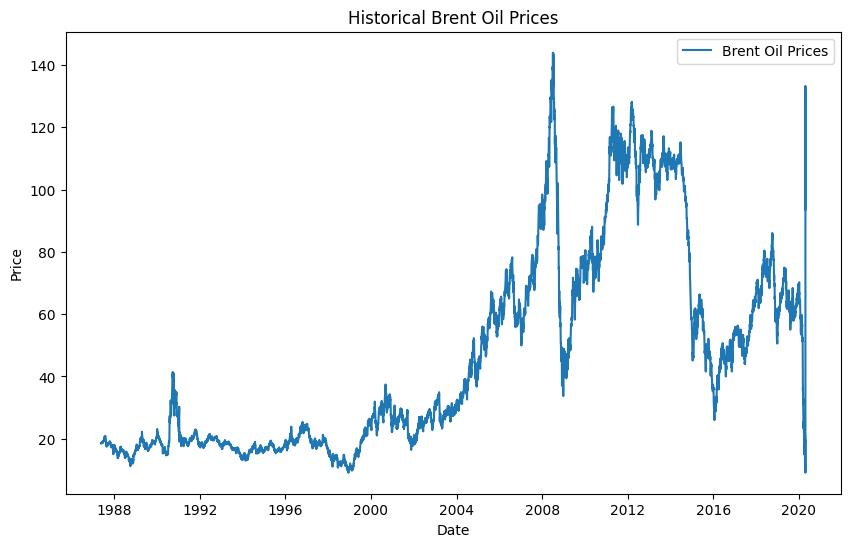

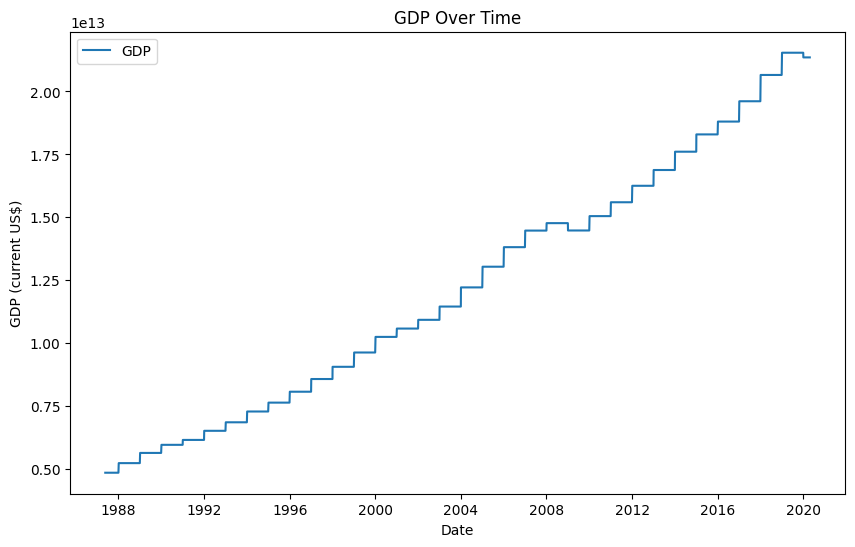

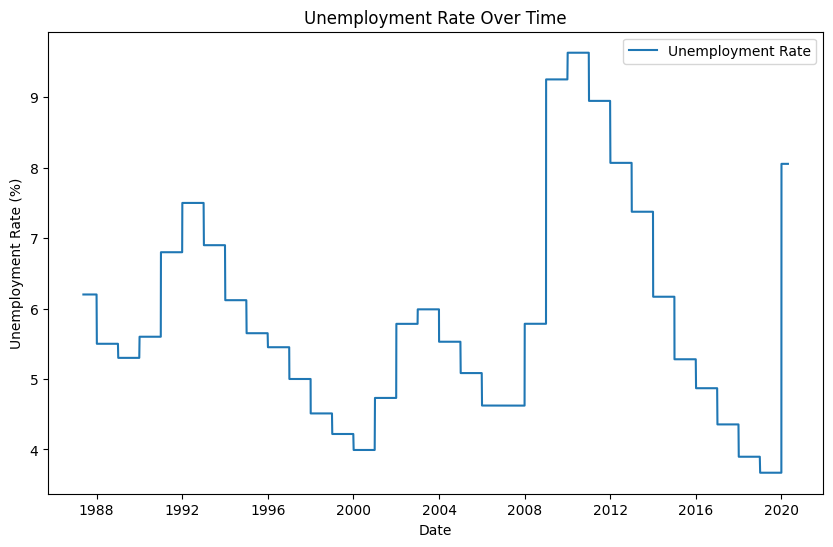

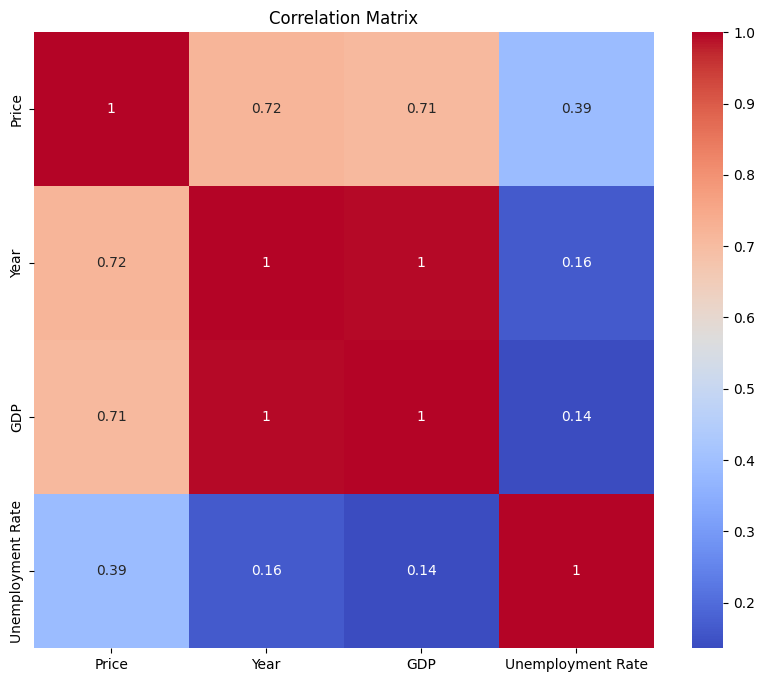

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that only numeric columns are selected
numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Plotting historical Brent oil prices
plt.figure(figsize=(10, 6))
plt.plot(merged_data.index, merged_data['Price'], label='Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical Brent Oil Prices')
plt.legend()
plt.show()

# Plotting GDP over time
plt.figure(figsize=(10, 6))
plt.plot(merged_data.index, merged_data['GDP'], label='GDP')
plt.xlabel('Date')
plt.ylabel('GDP (current US$)')
plt.title('GDP Over Time')
plt.legend()
plt.show()

# Plotting Unemployment Rate over time
plt.figure(figsize=(10, 6))
plt.plot(merged_data.index, merged_data['Unemployment Rate'], label='Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.title('Unemployment Rate Over Time')
plt.legend()
plt.show()

# Heatmap to check correlations using numeric columns only
plt.figure(figsize=(10, 8))
sns.heatmap(merged_data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [4]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model for Brent oil prices
arima_model = ARIMA(merged_data['Price'], order=(5, 1, 0))
arima_result = arima_model.fit()
print(arima_result.summary())


/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14540.613
Date:                Tue, 25 Feb 2025   AIC                          29093.226
Time:                        21:56:11   BIC                          29135.862
Sample:                             0   HQIC                         29107.733
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0260      0.006      4.344      0.000       0.014       0.038
ar.L2         -0.0235      0.006     -4.231      0.000      -0.034      -0.013
ar.L3         -0.0071      0.005     -1.507      0.1

In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR

# VAR model
var_model = VAR(merged_data[['Price', 'GDP', 'Unemployment Rate']])
var_result = var_model.fit()
print(var_result.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Feb, 2025
Time:                     21:56:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    43.4818
Nobs:                     9010.00    HQIC:                   43.4756
Log likelihood:          -234185.    FPE:                7.58233e+18
AIC:                      43.4724    Det(Omega_mle):     7.57224e+18
--------------------------------------------------------------------
Results for equation Price
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.114365         0.062226           -1.838           0.066
L1.Price                     0.998104         0.000609         1640.070           0.000
L1.GDP                       0.0

/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Data preparation for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['Price']])

# Creating training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Reshape data for LSTM [samples, time steps, features]
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

# LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, train_data.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_data, epochs=100, batch_size=32)

# Predictions
predictions = model.predict(test_data)
predictions = scaler.inverse_transform(predictions)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ARIMA Evaluation
arima_predictions = arima_result.forecast(steps=len(test_data))[0]
rmse_arima = np.sqrt(mean_squared_error(test_data, arima_predictions))
mae_arima = mean_absolute_error(test_data, arima_predictions)

# LSTM Evaluation
rmse_lstm = np.sqrt(mean_squared_error(test_data, predictions))
mae_lstm = mean_absolute_error(test_data, predictions)

print(f"ARIMA RMSE: {rmse_arima}, MAE: {mae_arima}")
print(f"LSTM RMSE: {rmse_lstm}, MAE: {mae_lstm}")
